In [44]:
pip install -q langchain langchain_community langchain-openai langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q tavily-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import operator
from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

# LLM Configuration

In [ ]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [34]:
llm = ChatOpenAI(model="gpt-4-turbo")

# State

In [35]:
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

# Planning Chain

In [ ]:
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [37]:
structured_plan = llm.with_structured_output(Plan)

c:\Users\carlv\OneDrive\Área de Trabalho\agents\langchain-env\Lib\site-packages\langchain_openai\chat_models\base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [38]:
plan_system = """For the given question, come up with a simple step-by-step plan to determine the correct answer.
This plan should involve individual reasoning steps, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
Make sure that each step includes all the information needed and builds logically toward generating the correct answer – do not skip any steps.
<QUESTION> {question} </QUESTION>
Provide the steps as a list, separated by newlines and without numbering."""
    
plan_prompt = ChatPromptTemplate.from_template(plan_system)

In [39]:
planner_chain = plan_prompt | structured_plan

# Executor Chain

In [40]:
tools = [TavilySearchResults(max_results=3)]

In [41]:
agent_executor = create_react_agent(llm, tools)

In [42]:
system = """You are an execution agent.
Your role is to carry out the given task exactly as planned.
Do not replan, revise, or question the task.
Focus solely on execution and deliver only the result."""
    
executor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{task}")
    ]
)

In [43]:
executor_chain = executor_prompt | llm | StrOutputParser()

# Re-Plan Chain

In [44]:
class Response(BaseModel):
    """Response to user."""

    response: str

In [50]:
class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [78]:
structured_plan = llm.with_structured_output(Act)

c:\Users\carlv\OneDrive\Área de Trabalho\agents\langchain-env\Lib\site-packages\langchain_openai\chat_models\base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [79]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given question, come up with a simple step-by-step plan to determine the correct answer.
This plan should involve individual reasoning steps that, if executed correctly, will yield the correct answer. Do not add any superfluous steps.
Make sure that each step includes all the information needed and builds logically toward identifying the correct answer – do not skip any steps.

Your multiple choice question was this:
{input}

Your original plan was this:
{plan}

You have currently completed the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that.
Otherwise, update the plan with the remaining reasoning steps needed to reach the answer. Do not repeat previously completed steps."""
)

In [80]:
replanner_chain = replanner_prompt | structured_plan

# Plan Function

In [96]:
def planner(state:PlanExecute):
    print("----CALLING PLANNER----")

    question = state["input"]

    plan = planner_chain.invoke({"question": question})

    print("----OUTPUT(PLAN)----")

    print(plan.steps)

    return {"plan": plan.steps}

# Executor Function

In [97]:
def execute_step(state: PlanExecute):
    print("----CALLING EXECUTOR----")
    plan = state["plan"]
    task = plan[0]
    agent_response = agent_executor.invoke({"messages": ["user", task]})
    print("----OUTPUT(TAVILY SEARCH)----")
    print(agent_response["messages"][-1].content)
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
        "plan": plan
    }

# Re-Plan Function

In [98]:
def replanner(state:PlanExecute):
    print("----RE-PLAN----")

    question = state["input"]
    past_steps = state["past_steps"]
    plan = state["plan"]

    output = replanner_chain.invoke({"input": question, "past_steps": past_steps, "plan": plan})

    print("----OUTPUT(REPLAN OR RESPONSE)----")

    print(output)

    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

# Router

In [99]:
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

# Graph

In [101]:
graph = StateGraph(PlanExecute)

graph.add_node("planner", planner)

graph.add_node("agent", execute_step)

graph.add_node("replan", replanner)

graph.add_edge(START, "planner")

graph.add_edge("planner", "agent")

graph.add_edge("agent", "replan")

graph.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

app = graph.compile()

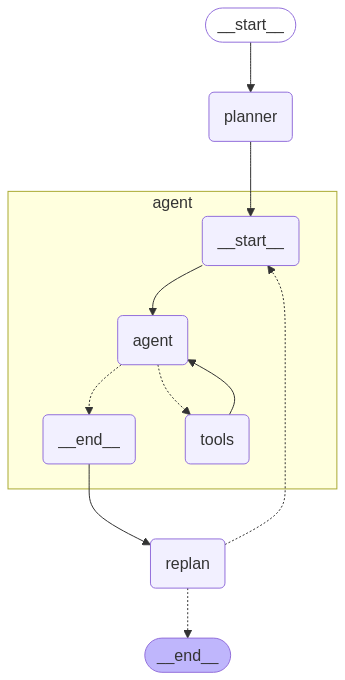

In [64]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [102]:
messages = "what is the hometown of the mens 2024 Australia open winner?"
result = app.invoke({"input": messages})
result

----CALLING PLANNER----
----OUTPUT(PLAN)----
["Identify the winner of the 2024 Men's Australian Open.", 'Research online or check reliable sports databases to find the hometown of the identified winner.']
----CALLING EXECUTOR----
----OUTPUT(TAVILY SEARCH)----
The winner of the 2024 Men's Australian Open is Jannik Sinner. He defeated Daniil Medvedev in the final with scores of 3-6, 3-6, 6-4, 6-4, 6-3 to claim his first major singles title.
----RE-PLAN----
----OUTPUT(REPLAN OR RESPONSE)----
action=Plan(steps=['Research online or check reliable sports databases to find the hometown of Jannik Sinner.'])
----CALLING EXECUTOR----
----OUTPUT(TAVILY SEARCH)----
Jannik Sinner's hometown is Sexten, located in the province of South Tyrol in Northern Italy.
----RE-PLAN----
----OUTPUT(REPLAN OR RESPONSE)----
action=Response(response="Jannik Sinner's hometown is Sexten, located in the province of South Tyrol in Northern Italy.")


{'input': 'what is the hometown of the mens 2024 Australia open winner?',
 'plan': ['Research online or check reliable sports databases to find the hometown of Jannik Sinner.'],
 'past_steps': [("Identify the winner of the 2024 Men's Australian Open.",
   "The winner of the 2024 Men's Australian Open is Jannik Sinner. He defeated Daniil Medvedev in the final with scores of 3-6, 3-6, 6-4, 6-4, 6-3 to claim his first major singles title."),
  ('Research online or check reliable sports databases to find the hometown of Jannik Sinner.',
   "Jannik Sinner's hometown is Sexten, located in the province of South Tyrol in Northern Italy.")],
 'response': "Jannik Sinner's hometown is Sexten, located in the province of South Tyrol in Northern Italy."}